## Navigating the Unicorn Landscape: Insights for Entrepreneurial Research

This notebook examines the dynamic world of `unicorn` startups – privately held companies valued at over $1 billion – and the influential investors behind them, as chronicled by the Midas List. This analysis aims to shed light on several critical themes pertinent to entrepreneurship, including attracting resources, growth strategies, strategic alliances, the unique contributions of immigrant ventures, gender differences in the investment ecosystem, and the broader impact of public policies.

By integrating data from global unicorn companies with insights into top venture capitalists, I seek to understand:

*   **Attracting Resources:** How do certain industries and regions become magnets for significant investment, and what factors contribute to a startup's ability to secure substantial funding?
*   **Growth Strategies:** What patterns emerge in the scaling trajectories of unicorns, particularly differentiating between rapid expansion and sustained growth across diverse sectors like AI and Fintech?
*   **Strategic Alliances:** While not explicitly detailed in direct alliances, the network of investors and their portfolio companies implicitly form a powerful ecosystem of connections and potential collaborations.
*   **Immigrant Ventures:** Explore geographical origins and investor profiles to infer potential contributions of immigrant founders and their impact on entrepreneurial hubs.
*   **Gender Differences:** An analysis of the Midas List investors to assess the gender distribution among top-tier venture capitalists, offering insights into diversity within the funding landscape and potential implications for funding patterns.
*   **Public Policies in Entrepreneurship:** Examine geographical distribution and industry focus, infer how regional policies and economic environments may foster or hinder the creation of high-growth ventures.

Through data-driven visualizations and analytical approaches, this notebook provides a contextual framework for investigating these complex entrepreneurial phenomena, offering a foundation for deeper academic inquiry.

In [5]:
import kagglehub
import pandas as pd
import os
import re
import ast
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# --- DATASET LOAD & CLEANING ---
path = kagglehub.dataset_download("ramjasmaurya/unicorn-startups")
csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
unicorns_df = pd.read_csv(os.path.join(path, csv_file))



100%|██████████| 36.8k/36.8k [00:00<00:00, 19.3MB/s]

Extracting files...


In [7]:
# 1. Standardize column HEADERS: Remove spaces, parentheses, and dollar signs
# turn "Valuation ($B)" into "valuation_b"
unicorns_df.columns = unicorns_df.columns.str.lower().str.replace(' ', '_').str.replace(r'[\(\)\$]', '', regex=True)



In [8]:
# 2. Rename the specific column for our analysis
# Check for 'valuation_b' (the cleaned version of the original header)
if 'valuation_b' in unicorns_df.columns:
    unicorns_df = unicorns_df.rename(columns={'valuation_b': 'valuation_billions'})
elif 'valuation' in unicorns_df.columns:
    unicorns_df = unicorns_df.rename(columns={'valuation': 'valuation_billions'})



In [9]:
# 3. Clean the DATA values: Remove '$', 'B', and any commas from the strings
# Fix the ValueError: could not convert string to float: '$140'
unicorns_df['valuation_billions'] = (
    unicorns_df['valuation_billions']
    .astype(str)
    .str.replace(r'[\$B\,]', '', regex=True)
    .astype(float)
)



In [10]:
# 4. Convert dates to datetime objects
unicorns_df['date_joined'] = pd.to_datetime(unicorns_df['date_joined'], errors='coerce')



In [11]:
# Preview the clean data
print(unicorns_df[['company', 'valuation_billions', 'date_joined']].head())

     company  valuation_billions date_joined
0  ByteDance               140.0  2017-04-07
1     SpaceX               127.0  2012-12-01
2      SHEIN               100.0  2018-07-03
3     Stripe                95.0  2014-01-23
4      Canva                40.0  2018-01-08


In [12]:
# --- PARSING THE MIDAS LIST ---
midas_raw = """
1
Alfred Lin
Sequoia
San Francisco, California, United States
OpenAI
2
Reid Hoffman
Greylock Partners
Palo Alto, California, United States
Airbnb
3
Peter Thiel
Founders Fund
Los Angeles, California, United States
Palantir
4
Neil Shen
HongShan
Hong Kong, China
ByteDance
5
Micky Malka
Ribbit Capital
Menlo Park, California, United States
Coinbase
6
Vinod Khosla
Khosla Ventures
Portola Valley, California, United States
Commonwealth Fusion Systems
7
Douglas Leone
Sequoia
Atherton, California, United States
Wiz
8
Hemant Taneja
General Catalyst
Palo Alto, California, United States
Applied Intuition
9
Fred Wilson
Union Square Ventures
New York, New York, United States
Coinbase
10
Chris Dixon
Andreessen Horowitz
Menlo Park, California, United States
Coinbase
11
Mike Speiser
Sutter Hill Ventures
San Francisco, California, United States
Snowflake
12
Richard Liu
5Y Capital
Hong Kong, China
XPeng
13
Roelof Botha
Sequoia
Menlo Park, California, United States
Natera
14
Satish Dharmaraj
Redpoint Ventures
Saratoga, California, United States
Snowflake
15
Saurabh Gupta
DST Global
San Francisco, California, United States
Chime
16
Avi Eyal
Entrée Capital
Tel Aviv, Israel
monday.com
17
Keith Rabois
Khosla Ventures
New York, New York, United States
Ramp
18
Marc Andreessen
Andreessen Horowitz
Menlo Park, California, United States
Samsara
19
Trae Stephens
Founders Fund
San Francisco, California, United States
Anduril
20
Navin Chaddha
Mayfield
Menlo Park, California, United States
Poshmark
21
Martin Mignot
Index Ventures
New York, United States
Revolut
22
Mamoon Hamid
Kleiner Perkins
Atherton, California, United States
Slack
23
Eric Vishria
Benchmark
Atherton, California, United States
Cerebras
24
Gili Raanan
Cyberstarts
Michmoret, Israel
Wiz
25
Randy Glein
DFJ Growth
San Mateo, California, United States
SpaceX
26
Saar Gur
CRV
San Francisco, California, United States
DoorDash
27
David Frankel
Founder Collective
Brookline, Massachusetts, United States
Shield AI
28
Pawel Chudzinski
Point Nine Capital
Berlin, Germany
Revolut
29
Yi Cao
Source Code Capital
China
ByteDance
30
Topher Conway
SV Angel
San Francisco, California, United States
Rippling
31
Tuck Lye Koh
Shunwei Capital
Beijing, China
Xiaomi
32
Scott Raney
Redpoint Ventures
Menlo Park, California, United States
Stripe
33
Ben Horowitz
Andreessen Horowitz
Menlo Park, California, United States
Databricks
34
Hurst Lin
DCM
Beijing, China
Kuaishou
35
Marc Stad
Dragoneer Investment Group
San Francisco, California, United States
Uber
36
Pat Grady
Sequoia
Portola Valley, California, United States
Snowflake
37
Barry Schuler
DFJ Growth
Napa, California, United States
Coinbase
38
Neil Mehta
Greenoaks
San Francisco, California, United States
Coupang
39
Xi Cao
Monolith
Beijing, China
Kuaishou
40
Brad Gerstner
Altimeter Capital
Woodside, California, United States
Snowflake
41
Shardul Shah
Index Ventures
New York, New York, United States
Wiz
42
Ben Sun
Primary Venture Partners
New York, New York, United States
Coupang
43
Tom Stafford
DST Global
London, United Kingdom
Nubank
44
Mar Hershenson
Pear VC
Los Altos, California, United States
DoorDash
45
Nicolas Szekasy
Kaszek
Montevideo, Uruguay
Nubank
46
Pejman Nozad
Pear VC
Atherton, California, United States
DoorDash
7
Fisher Zhang
5Y Capital
Hong Kong, China
Kuaishou
48
Mike Volpi
Index Ventures
Woodside, California, United States
Confluent
49
Mary Meeker
BOND
United States
Canva
50
Jan Hammer
Index Ventures
London, United Kingdom
Robinhood
51
Luciana Lixandru
Sequoia
London, United Kingdom
UiPath
52
Meng Lian
IDG Capital
Guangzhou, China
Shein
53
Koichiro Nakamura
Sozo Ventures
Los Gatos, California, United States
Palantir
54
David George
Andreessen Horowitz
Menlo Park, California, United States
Roblox
55
Ravi Mhatre
Lightspeed Venture Partners
Menlo Park, California, United States
Rubrick
56
Peter Fenton
Benchmark
San Francisco, California, United States
Airtable
57
Allen Zhu
GSR Ventures
Shanghai, China
DiDi Chuxing
58
Larry Li
Amino Capital
Palo Alto, California, United States
Chime
59
Philippe Botteri
Accel
London, United Kingdom
Docusign
60
Byron Deeter
Bessemer Venture Partners
Atherton, California, United States
Twilio
61
Ronny Conway
A.Capital
San Francisco, California, United States
Notion
62
Anna Fang
ZhenFund
Beijing, China
Xiaohongshu
63
Lucas Swisher
Coatue Management
San Francisco, California, United States
UiPath
64
David B. Singer
Maverick Ventures
San Francisco, California, United States
One Medical
65
Jixun Foo
Granite Asia
Shanghai, China
Grab
66
Ilya Fushman
Kleiner Perkins
Atherton, California, United States
Loom
67
Max Gazor
CRV
San Francisco, California, United States
Airtable
68
Chetan Puttagunta
Benchmark
San Francisco, California, United States
Elastic
69
Daniel Levine
Accel
San Francisco, California, United States
Scale AI
70
Kirsten Green
Forerunner Ventures
United States
Chime
71
Xiaojun Li
IDG Capital
Boston, Massachusetts, United States
Xiaomi
72
Ashvin Bachireddy
SV Angel
Menlo Park, California, United States
Databricks
73
Rahul Mehta
DST Global
Dubai, United Arab Emirates
DoorDash
74
Lauren Kolodny
Acrew Capital
San Francisco, California, United States
Chime
75
Jenny Lee
Granite Asia
Singapore
Kingsoft WPS
76
Lee Fixel
Addition
New York, New York, United States
Flipkart
77
Matt Witheiler
Wellington Management
Denver, Colorado, United States
Scale
78
John Lindfors
DST Global
Hong Kong, China
Kuaishou
79
Aydin Senkut
Felicis Ventures
Atherton, California, United States
Credit Karma
80
Shaun Maguire
Sequoia
Menlo Park, California, United States
SpaceX
81
Salil Deshpande
Uncorrelated
Palo Alto, California, United States
Redis
82
Nisa Leung
Qiming Venture Partners
Hong Kong, China
Alamar Biosciences
83
Pete Sonsini
Laude Ventures
Atherton, California, United States
Databricks
84
Brian Singerman
Founders Fund
San Francisco, California, United States
Anduril
85
David Sacks
Craft Ventures
San Francisco, California, United States
SpaceX
86
Wesley Chan
FPV
Jackson Hole, Wyoming, United States
Canva
87
Elad Gil
Gil Capital
San Francisco, California, United States
Stripe
88
Ross Fubini
XYZ Venture Capital
San Francisco, California, United States
Anduril
89
Josh Kopelman
First Round
Philadelphia, Pennsylvania, United States
Clover Health
90
Nigel Morris
QED Investors
Alexandria, Virginia, United States
Nubank
91
Rich Wong
Accel
Hillsborough, California, United States
UiPath
92
Robert Nelsen
ARCH Venture Partners
San Francisco, California, United States
Karuna Therapeutics
93
Annie Lamont
Oak HC/FT
Greenwich, Connecticut, United States
Carebridge
94
Danny Rimer
Index Ventures
London, United Kingdom
Figma
95
Scott Sandell
New Enterprise Associates
Palm Beach, Florida, United States
Cloudflare
96
Adam Ross
Goldcrest Capital
Dallas, Texas, United States
Anduril
97
David Su
Matrix Partners China
Shanghai, China
XPeng
98
Hans Tung
Notable Capital
San Francisco, California, United States
Ibotta
99
Reshma Sohoni
Seedcamp
Miami, Florida, United States
Synthesia
100
Eric Liaw
Institutional Venture Partners
London, United Kingdom
UiPath"""

# Regular Expression to find blocks of 5 lines
# Pattern: (Rank)\n(Name)\n(Firm)\n(Location)\n(Notable Deal)
pattern = r"(\d+)\n(.+)\n(.+)\n(.+)\n(.+)"

# Find all matches
matches = re.findall(pattern, midas_raw)

# Create the DataFrame
midas_df = pd.DataFrame(matches, columns=['rank', 'name', 'firm', 'location', 'notable_deal'])

# Convert rank to integer for proper sorting
midas_df['rank'] = midas_df['rank'].astype(int)

print(midas_df.head())


   rank          name               firm  \
0     1    Alfred Lin            Sequoia   
1     2  Reid Hoffman  Greylock Partners   
2     3   Peter Thiel      Founders Fund   
3     4     Neil Shen           HongShan   
4     5   Micky Malka     Ribbit Capital   

                                   location notable_deal  
0  San Francisco, California, United States       OpenAI  
1      Palo Alto, California, United States       Airbnb  
2    Los Angeles, California, United States     Palantir  
3                          Hong Kong, China    ByteDance  
4     Menlo Park, California, United States     Coinbase  


In [13]:
midas_df['first_name'] = midas_df['name'].apply(lambda x: x.split(' ')[0])
print(midas_df.head())

   rank          name               firm  \
0     1    Alfred Lin            Sequoia   
1     2  Reid Hoffman  Greylock Partners   
2     3   Peter Thiel      Founders Fund   
3     4     Neil Shen           HongShan   
4     5   Micky Malka     Ribbit Capital   

                                   location notable_deal first_name  
0  San Francisco, California, United States       OpenAI     Alfred  
1      Palo Alto, California, United States       Airbnb       Reid  
2    Los Angeles, California, United States     Palantir      Peter  
3                          Hong Kong, China    ByteDance       Neil  
4     Menlo Park, California, United States     Coinbase      Micky  


In [14]:
pip install gender-guesser

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 7.2 MB/s eta 0:00:00


In [15]:

# --- GENDER IMPUTATION (Maturity of the Ecosystem) ---
# Note: Requires !pip install gender-guesser
import gender_guesser.detector as gender
d = gender.Detector(case_sensitive=False)
midas_df['first_name'] = midas_df['name'].apply(lambda x: x.split(' ')[0])
midas_df['gender'] = midas_df['first_name'].apply(lambda x: d.get_gender(x).replace('mostly_', ''))


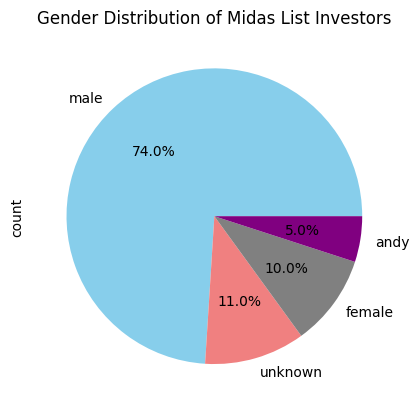

In [16]:

# --- VISUALIZATION: DIVERSITY IN VENTURE ---
gender_counts = midas_df['gender'].value_counts()
gender_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'gray', 'purple'], title='Gender Distribution of Midas List Investors')
plt.show()

/tmp/ipython-input-801786823.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=unicorns_df, x='is_europe', y='valuation_billions', palette='Purples')


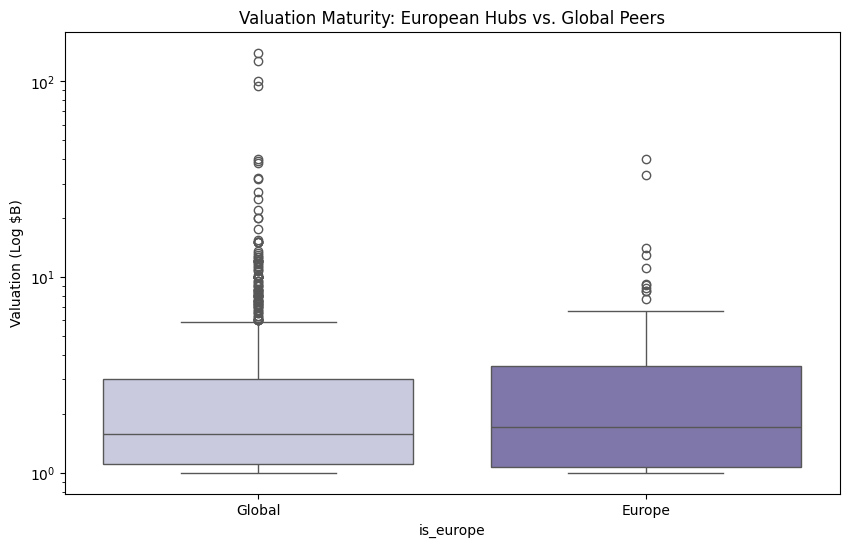

In [17]:
# --- ANALYSIS: WHERE DOES THE CAPITAL FLOW? ---
# Identify which Midas firms are the most "Prolific" in the Unicorn dataset
exploded_unicorns = unicorns_df.explode('investors')
top_firms = exploded_unicorns['investors'].value_counts().head(10)

# Alignment with European Context
european_hubs = ['Denmark', 'Sweden', 'Norway', 'Germany', 'United Kingdom', 'France', 'Netherlands']
unicorns_df['is_europe'] = unicorns_df['country'].isin(european_hubs)

plt.figure(figsize=(10, 6))
sns.boxplot(data=unicorns_df, x='is_europe', y='valuation_billions', palette='Purples')
plt.yscale('log')
plt.title('Valuation Maturity: European Hubs vs. Global Peers')
plt.xticks([0, 1], ['Global', 'Europe'])
plt.ylabel('Valuation (Log $B)')
plt.show()

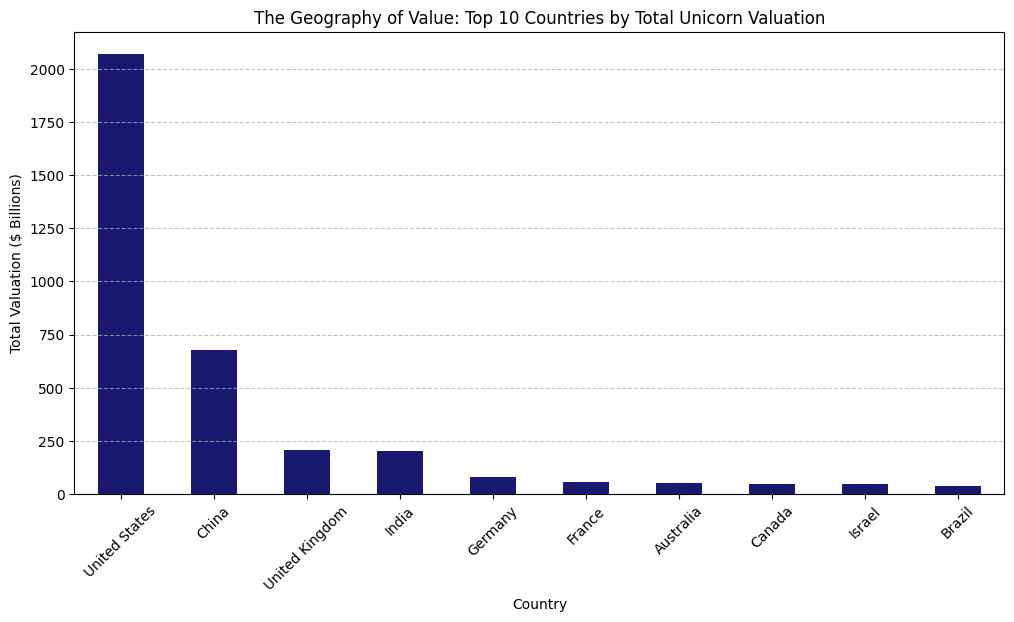

In [18]:
# 1. Aggregate total valuation by country
top_valuation_countries = (
    unicorns_df.groupby('country')['valuation_billions']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# 2. Plot
plt.figure(figsize=(12, 6))
top_valuation_countries.plot(kind='bar', color='midnightblue')
plt.title('The Geography of Value: Top 10 Countries by Total Unicorn Valuation')
plt.ylabel('Total Valuation ($ Billions)')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


/tmp/ipython-input-1139202655.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=gender_compare, x='gender', y='rank', palette='Set2')


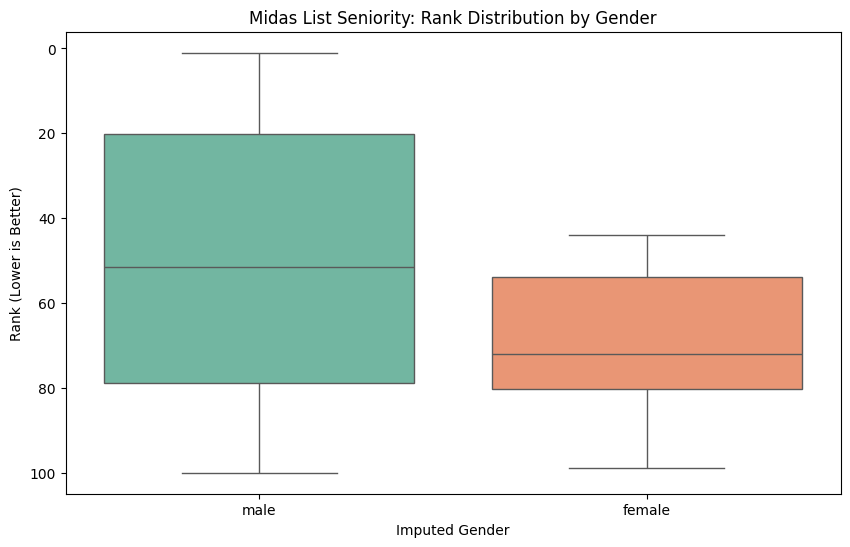

In [19]:
# 1. Filter out 'unknown' and 'andy' for a cleaner comparison
gender_compare = midas_df[midas_df['gender'].isin(['male', 'female'])]

# 2. Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=gender_compare, x='gender', y='rank', palette='Set2')
plt.title('Midas List Seniority: Rank Distribution by Gender')
plt.ylabel('Rank (Lower is Better)')
plt.xlabel('Imputed Gender')
# Invert y-axis because Rank 1 is higher than Rank 100
plt.gca().invert_yaxis()
plt.show()

In [20]:
# Download latest version
path = kagglehub.dataset_download("ramjasmaurya/unicorn-startups")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'unicorn-startups' dataset.
Path to dataset files: /kaggle/input/unicorn-startups


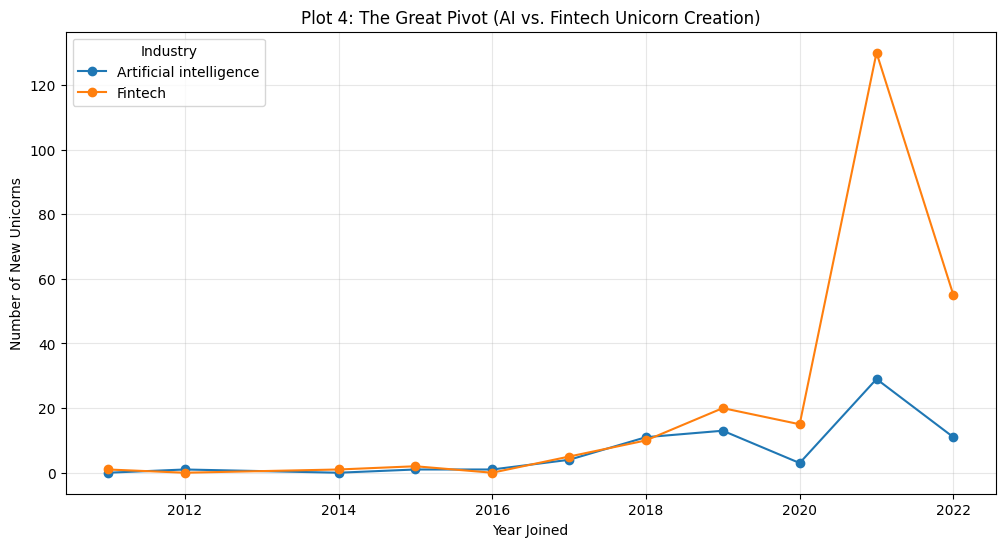

In [23]:
# Filter and explode to track yearly creation counts
pivot_df = unicorns_df.explode('industry')
pivot_df = pivot_df[pivot_df['industry'].isin(['Artificial intelligence', 'Fintech'])]

trend_data = (
    pivot_df.groupby([pivot_df['date_joined'].dt.year, 'industry'])
    .size()
    .unstack(fill_value=0)
)

trend_data.plot(kind='line', marker='o', figsize=(12, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Plot 4: The Great Pivot (AI vs. Fintech Unicorn Creation)')
plt.ylabel('Number of New Unicorns')
plt.xlabel('Year Joined')
plt.grid(True, alpha=0.3)
plt.legend(title='Industry')
plt.show()


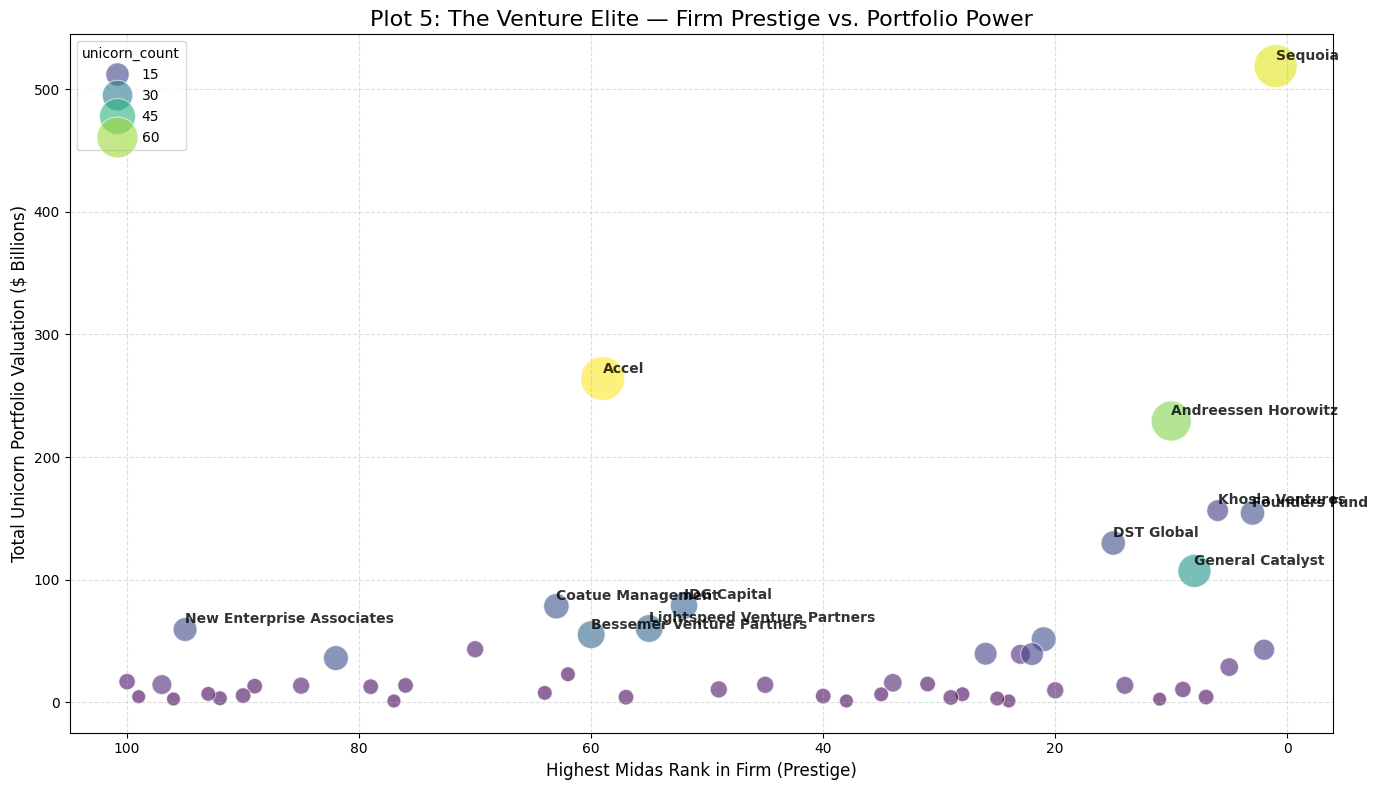

Analysis complete: Successfully matched 51 Midas firms to the Unicorn dataset.


In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare Midas Firm "Prestige" Data
# Find best (minimum) rank for each firm to represent their prestige
firm_prestige = midas_df.groupby('firm')['rank'].min().reset_index()
firm_prestige.columns = ['midas_firm', 'best_rank']

# 2. Explode the Unicorn Investors for matching
exploded_unicorns = unicorns_df.explode('investors')

# 3. Robust "Fuzzy" Matching Logic
# Check if a Midas Firm name is contained within the Unicorn Investor string
midas_firms_list = firm_prestige['midas_firm'].unique()

def match_midas_firm(investor_name):
    if not isinstance(investor_name, str): return None
    investor_name_lower = investor_name.lower().strip()
    for firm in midas_firms_list:
        firm_lower = firm.lower().strip()
        # Match if the Midas firm name is a subset of the Unicorn investor name
        if firm_lower in investor_name_lower or investor_name_lower in firm_lower:
            return firm
    return None

# Apply the matching
exploded_unicorns['matched_midas_firm'] = exploded_unicorns['investors'].apply(match_midas_firm)

# 4. Aggregate Portfolio Data by Matched Firm
firm_portfolio = exploded_unicorns.dropna(subset=['matched_midas_firm']).groupby('matched_midas_firm').agg(
    total_valuation=('valuation_billions', 'sum'),
    unicorn_count=('company', 'nunique')
).reset_index()

# 5. Join Prestige and Portfolio Data
final_analysis = pd.merge(firm_portfolio, firm_prestige, left_on='matched_midas_firm', right_on='midas_firm')

# 6. Scatter Plot: Prestige (Rank) vs. Portfolio Power (Valuation)
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    data=final_analysis,
    x='best_rank',
    y='total_valuation',
    size='unicorn_count',
    hue='unicorn_count',
    sizes=(100, 1000),
    palette='viridis',
    alpha=0.6
)

# Label top-performing firms for detail
top_labels = final_analysis.sort_values('total_valuation', ascending=False).head(12)
for i, row in top_labels.iterrows():
    plt.text(row['best_rank'], row['total_valuation'] + 5, row['midas_firm'],
             fontsize=10, weight='bold', alpha=0.8)

# Formatting
plt.title('Plot 5: The Venture Elite — Firm Prestige vs. Portfolio Power', fontsize=16)
plt.xlabel('Highest Midas Rank in Firm (Prestige)', fontsize=12)
plt.ylabel('Total Unicorn Portfolio Valuation ($ Billions)', fontsize=12)
plt.gca().invert_xaxis() # Rank 1 is on the right, invert so it's on the far "Elite" side
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print(f"Analysis complete: Successfully matched {len(final_analysis)} Midas firms to the Unicorn dataset.")